# Implements encoder/decoder for weak lensing outputs or an image transformer

The major idea is to see if I can compress the data in the snapshot files.
The result is that the compression of many different algorithms based on CNNs (of different depths) is not so much different than averaging neighboring cells (as shown at the end).  This in retrospect is not so surprising as there are differences on the cell scale in the maps that make compression challenging.

Set configurations for google COLAB if running there (to use their GPUs)

In [1]:
import os


use_COLAB = 0 #1 is for on colab, and 2 is for on local machine but using colab

if use_COLAB >= 1:
  if use_COLAB == 2: # for running in VS CODE
      from colabcode import ColabCode
      ColabCode(port=10000)
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)


### extract tarfiles if necessary and set specs for run

(we are only using Weak lensing maps here)



In [2]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#whether we are training or loading saved
train = True
load_saved = 1

# Specify the directory containing the .tar files
if use_COLAB >= 1:
    directory_path = './columbialensing/'
else:
        directory_path = '../weaklensing_ML/columbialensing/'
number_batches = 10
#normalize_by_RMS = True #set to one if you want to renormalize by RMS

# image_size
image_size = 1024
sub_image_size = 32 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations
number_fits_files = 16 # just sto start


number_subimages_across =image_size//sub_image_size




#extracts only if indicated (could make this more elegant by checking to see if they exist)
extract_tarfiles = False  #if need to unpack tarfiles before reading in
suffix = f"_{image_size}"
run_suffix = rf"im{image_size}"
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)




Num GPUs Available:  1


# Read into memory the data

two important parameters are set here


bool normalize_by_RMS   -- normalizes to RMS of data (probably always want to do this as it makes errors and other things easier to interpret
                       it doesn't impact compression as you can always pass this float as well
bool LOGFIELD --   whether you want to log the field or not.  Try both

In [4]:
#parameters we need
normalize_by_RMS = True #normalizes to RMS of data (probably always want to do this as it makes errors and other things easier to interpret
                       #it doesn't impact compression as you can always pass this float as well
LOGFIELD = True  #whether you want to log the field or not.  Try both

def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float32)

number_subimages_total = 0
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        if idx >= number_fits_files:
            break

        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            #if RMS == 0: #get RMS to divide by for first file to normalize everything
            #    RMS = np.sqrt(np.var(hdul[0].data))
            #    print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]
                number_subimages_total +=1



    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]

if LOGFIELD:
    meanf = np.mean(data_array)
    stdf = np.std(data_array)
    minf = np.min(data_array)
    data_array = np.log((data_array-minf)/stdf + 1e-3)  #this was 1e-30 before 10/29/24, but 1e-3 makes sense to me
    print("LOGFIELD = True :  mean, std, min", meanf, stdf, minf)
elif normalize_by_RMS:
    stdf = np.std(data_array)
    data_array = data_array/stdf
    print(stdf)
    print("normalize_by_RMS = True : std", stdf)

WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension



reading in Om0.268_si0.801
LOGFIELD = True :  mean, std, min 0.00015788472 0.018293597 -0.034070354


#$ Let's make an image

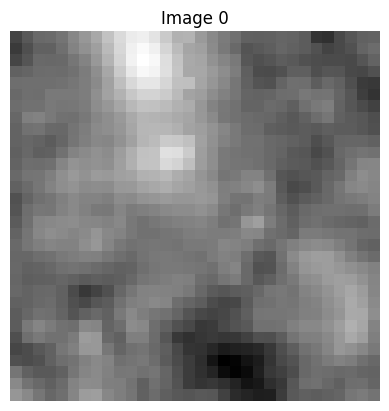

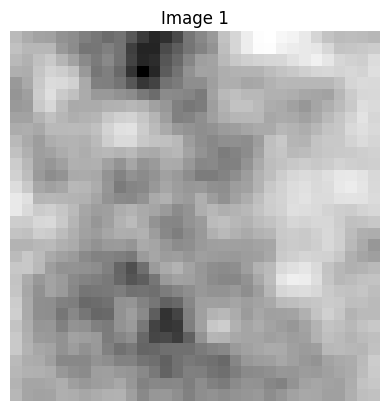

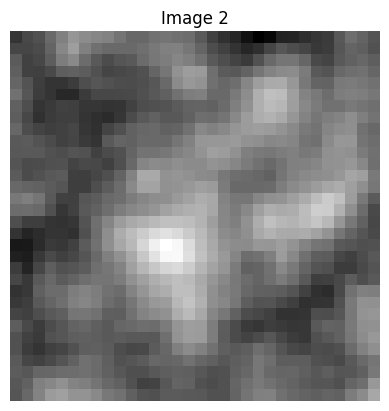

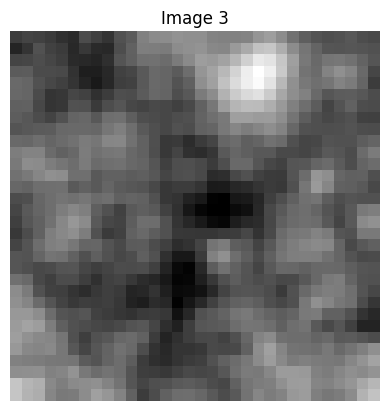

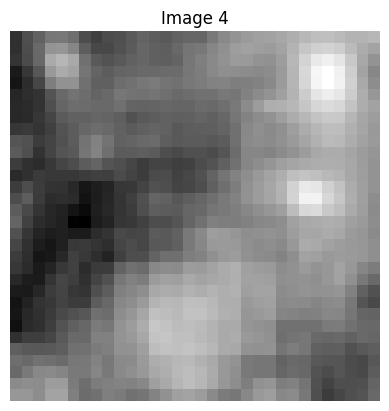

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

# Number of images you want to display
num_images_to_display = 5

for i in range(num_images_to_display):
    # Extract the i-th image tensor
    image_tensor = WL_tensor[i, :, :, 0]
    # Use TensorFlow operations if needed (optional)
    # Display the image
    plt.imshow(image_tensor, cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()


#### print out some dimensions of arrays 

In [5]:
print("number_subimages_across =", number_subimages_across )
print("total number of images =", number_subimages_across*number_subimages_across*number_fits_files *len(all_directories), number_subimages_total)
np.shape(WL_tensor)

number_subimages_across = 32
total number of images = 16384 512


TensorShape([16384, 32, 32, 1])

## functions to calculate statistics of distribution of pixel values

Number of NaNs: 0
Number of Infinities: 0
Min value: -1.1941020488739014
Max value: 2.4392032623291016
Tensor shape: (17, 32, 32, 1)
Mean value: 0.4890615940093994
Variance value: 0.17789484560489655
Mean value: 0.48906160283867894
Variance value: 0.17790506583065654
Standard Deviation: 0.42177581787109375


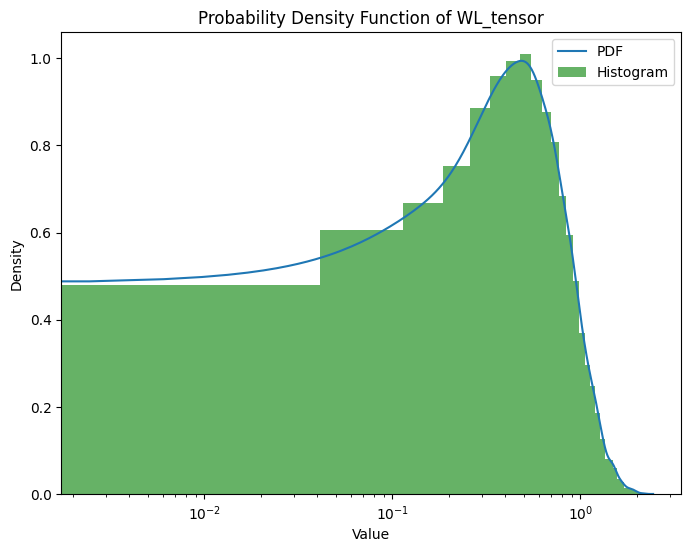

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import tensorflow as tf


# Implement Welford's algorithm for numerically stable mean and variance calculation
def welford_algorithm(data):
    n = 0
    mean = 0.0
    M2 = 0.0

    for x in data:
        n += 1
        delta = x - mean
        mean += delta / n
        delta2 = x - mean
        M2 += delta * delta2

    variance = M2 / (n - 1) if n > 1 else float('nan')
    return mean, variance

calculate_statistics = True

if calculate_statistics:
    # Assuming WL_tensor is a TensorFlow tensor of floating-point numbers

    # Convert the TensorFlow tensor to a NumPy array
    WL_tensor_np = WL_tensor.numpy()
    WL_tensor_np = WL_tensor_np[::1000, :, :, :]  # Downsample the tensor for faster computation

    # Check for NaNs and Infinities
    num_nans = np.isnan(WL_tensor_np).sum()
    num_infs = np.isinf(WL_tensor_np).sum()
    print(f"Number of NaNs: {num_nans}")
    print(f"Number of Infinities: {num_infs}")


    # Inspect the range of values
    min_value = WL_tensor_np.min()
    max_value = WL_tensor_np.max()
    print(f"Min value: {min_value}")
    print(f"Max value: {max_value}")

    # Check the shape of the tensor
    tensor_shape = WL_tensor_np.shape
    print(f"Tensor shape: {tensor_shape}")

    # Manually calculate the mean and variance
    mean_value = np.mean(WL_tensor_np)
    variance_value = np.var(WL_tensor_np)
    print(f"Mean value: {mean_value}")
    print(f"Variance value: {variance_value}")


    # Flatten the tensor to 1D for easier processing
    WL_tensor_flat = WL_tensor_np.flatten()




    # Calculate mean and variance using Welford's algorithm
    mean_value, variance_value = welford_algorithm(WL_tensor_flat)
    print(f"Mean value: {mean_value}")
    print(f"Variance value: {variance_value}")


    # Calculate the standard deviation
    std_dev = np.std(WL_tensor_np)
    print(f"Standard Deviation: {std_dev}")

    DO_KDE= True
    if DO_KDE:
        # Flatten the tensor to 1D for PDF calculation
        WL_tensor_flat = WL_tensor_np.flatten()

        # Calculate the PDF using Gaussian Kernel Density Estimation
        kde = gaussian_kde(WL_tensor_flat)
        x_values = np.linspace(WL_tensor_flat.min(), WL_tensor_flat.max(), 1000)
        pdf_values = kde(x_values)

        # Plot the PDF
        plt.figure(figsize=(8, 6))
        plt.semilogx(x_values, pdf_values, label='PDF')
        plt.hist(WL_tensor_flat, bins=50, density=True, alpha=0.6, color='g', label='Histogram')
        plt.title('Probability Density Function of WL_tensor')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

# Motivated binning method that partitions so that variance in each bin should be the same

really we want to learn the bins and not choose them from the start (in LLMs this is the tokenization step)

In [11]:
import numpy as np
import tensorflow as tf

# Flatten the tensor to 1D for easier processing
WL_tensor_flat =  tf.reshape(WL_tensor, [-1]) # WL_tensor_np.flatten()

# Ensure WL_tensor_flat is a NumPy array
if isinstance(WL_tensor_flat, tf.Tensor):
    WL_tensor_flat_np = WL_tensor_flat.numpy()
else:
    WL_tensor_flat_np = WL_tensor_flat

# Step 1: Sample a Subset of the Data
sample_size = 10_000_000  # Adjust based on available memory and desired accuracy

if sample_size  > len(WL_tensor_flat_np):
    sampled_data = WL_tensor_flat_np
else:
    indices = np.random.choice(len(WL_tensor_flat_np), size=sample_size, replace=False)
    sampled_data = WL_tensor_flat_np[indices]


# Step 2: Sort the Sampled Data
sorted_data = np.sort(sampled_data)
n = len(sorted_data)


#print("num zeros = ", np.sum(sampled_data == 0), np.sum(WL_tensor_flat_np == 0), np.sum(sorted_data ==0))

#print("sorted_data =", sorted_data)

# Step 3: Compute Cumulative Sums and Cumulative Sum of Squares
cum_sum = np.cumsum(sorted_data, dtype=float)
cum_sum_sq = np.cumsum(sorted_data**2, dtype=float)

# Step 4: Compute Total Variance and Target Variance per Bin
target_std = .1
target_variance = target_std**2
num_bins= 50 # just a guess to start
MIN_BIN_SIZE = 10  # Adjust based on your data size and acceptable error


for iiter in range(5): # iterate five times to reach target std

    target_variance_per_bin = target_variance/ num_bins

    print(f"Target Variance: {target_variance}")
    print(f"Target Variance per Bin: {target_variance_per_bin}")


    # Step 5: Find Bin Edges
    bin_edges = []
    num_points_arr = []
    total_variance_bin_arr = []
    mean_bin_arr = []

    start_index = 0
    while start_index < n:
        found = False
        for end_index in range(start_index + MIN_BIN_SIZE, n):
            num_points = end_index - start_index + 1
            #if num_points <= 3:
            #    continue
            # Sum and sum of squares in the bin
            sum_bin = cum_sum[end_index] - (cum_sum[start_index - 1] if start_index > 0 else 0)
            sum_sq_bin = cum_sum_sq[end_index] - (cum_sum_sq[start_index - 1] if start_index > 0 else 0)
            # Mean and variance in the bin
            mean_bin = sum_bin / num_points
            total_variance_bin = (sum_sq_bin - num_points*mean_bin**2)/(num_points-1)*num_points/n  #total contribute to variance
            if total_variance_bin >= target_variance_per_bin:
                bin_edges.append(sorted_data[end_index])
                num_points_arr.append(num_points)
                total_variance_bin_arr.append(total_variance_bin)
                mean_bin_arr.append(mean_bin)
                #print("sums = ",  sum_bin , sum_sq_bin, mean_bin, sum_sq_bin / num_points, num_points, "total_variance_bin = ", total_variance_bin, target_variance_per_bin, num_points/n, ((sum_sq_bin / num_points) - mean_bin**2) )
                #print("indexes =", start_index, end_index, cum_sum[end_index], cum_sum_sq[start_index - 1]) 
                start_index = end_index + 1
                found = True
                break
        if not found:
            # Include all remaining data in the last bin
            bin_edges.append(tf.reduce_max(WL_tensor)) #       sorted_data[-1])
            break

    num_bins = len(bin_edges)
    print("num bins=", num_bins)

print("done with calculating number of bins")

# Step 6: Digitize the Original Data Using Bin Edges
# Convert bin_edges to numpy array for consistency
bin_edges = np.array(bin_edges)

# Use np.digitize to find bin indices for the entire dataset
bin_indices = np.digitize(WL_tensor_flat_np, bin_edges, right=True)-1

# Adjust bin_indices to ensure they are within the valid range
# Since mean_values has length len(bin_edges) + 1, bin_indices should be in [0, len(bin_edges)]
#may be necessary since our bins are not based on everything
bin_indices = np.clip(bin_indices, 0, len(bin_edges))


# Digitize the tensor values according to the binning scheme
#bin_indices = tf.searchsorted(bin_edges, WL_tensor_flat, side='right') - 1


#let's calculate the mean we expect in each bin
#MIGHT NEED TO GAURD AGAINST ZEROS
mean_values = [np.mean(WL_tensor_flat[bin_indices == index]) for index in range(len(bin_edges)-1)]




print("mean values = ", mean_values)
print("bin_edges = ", bin_edges)
print("num_points = ", num_points_arr)
print("total_variance_bin =", total_variance_bin_arr)

encoded_tensor = tf.gather(mean_values, bin_indices) #realization of quantized tensor


#reshape
bin_indices = tf.reshape(bin_indices, [number_images,  sub_image_size*sub_image_size])


# Compute mean values
# mean_values = np.zeros(len(bin_edges) + 1)
# for i in range(len(mean_values)):
#     indices_in_bin = bin_indices == i
#     if np.any(indices_in_bin):
#         mean_values[i] = np.mean(WL_tensor_flat_np[indices_in_bin])
#     else:
#         # Handle empty bins if necessary
#         mean_values[i] = 0

# # Map bin indices to mean values
# encoded_tensor_np = mean_values[bin_indices]

# # If you need to convert back to a TensorFlow tensor
# encoded_tensor = tf.convert_to_tensor(encoded_tensor_np, dtype=WL_tensor_flat.dtype)

# # Compute Quantization Error
# 
# 
diff_tensor = encoded_tensor - WL_tensor_flat

# Compute the standard deviation of the quantization error
std_quantized = tf.math.reduce_std(diff_tensor).numpy()

# Convert indices to a TensorFlow tensor
indices_tf = tf.constant(indices, dtype=tf.int32)
# Use tf.gather to index diff_tensor
std_quantized_sampled = tf.math.reduce_std(tf.gather(diff_tensor, indices_tf)).numpy()

print("##########################################")
print("Standard Deviation of Quantization Error:", std_quantized, std_quantized_sampled, np.sum(total_variance_bin_arr)**.5)
print("##########################################")
# If needed, reshape encoded_tensor back to the original tensor shape
# encoded_tensor = tf.reshape(encoded_tensor, WL_tensor.shape)

#just to check quantization works
print(encoded_tensor[-10:])
print(WL_tensor_flat[-10:])


print(diff_tensor[-10:])


print(num_points_arr, np.sum(num_points_arr))
print(total_variance_bin_arr, np.sum(total_variance_bin_arr))


Target Variance: 0.010000000000000002
Target Variance per Bin: 0.00020000000000000004
num bins= 15
Target Variance: 0.010000000000000002
Target Variance per Bin: 0.0006666666666666668
num bins= 10
Target Variance: 0.010000000000000002
Target Variance per Bin: 0.0010000000000000002
num bins= 9
Target Variance: 0.010000000000000002
Target Variance per Bin: 0.0011111111111111113
num bins= 8
Target Variance: 0.010000000000000002
Target Variance per Bin: 0.0012500000000000002
num bins= 8
done with calculating number of bins
mean values =  [-0.1482372, 0.23132344, 0.48518446, 0.7403438, 1.0323923, 1.428342, 2.0469747]
bin_edges =  [-0.27657598  0.08495405  0.3580989   0.61281127  0.88676727  1.2324514
  1.8156495   3.4240055 ]
num_points =  [346527, 1262608, 2060749, 2340940, 2043048, 1330312, 551527]
total_variance_bin = [0.0012500027011464942, 0.0012500002575710613, 0.0012500002435982258, 0.0012500014692704898, 0.001250001326376575, 0.0012500004766762308, 0.0012500107019120814]
###########

# Autoregressive image transformer 

## Autoregressive transformer with sinusoidal 2D positional encoding

The model uses sinusoidal positional encodings (combining sines and cosines at different frequencies)
to encode 2D spatial position information, sampled up to the Nyquist frequency.
This variant compares performance across two model depths: a deeper and a shallower architecture.

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt


# Parameters for the network
n_trans_layers = 2  # Number of Transformer layers
number_channels = sub_image_size  # Embedding dimension (d_model)
act_string = 'relu'
dropout_rate = 0.1
L1weight = 0  #don't think need L1 and dropout  (I've tested and it performs best with this equal to zero)

num_classes = num_bins  # Set num_classes to num_bins: this is the number of values that can be populated
d_model = number_channels*2  # Embedding dimension
d_ff = d_model * 4  # Feed-forward network dimension
num_heads = 8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

# Custom Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, height, width, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.height = height
        self.width = width
        self.d_model = d_model
        self.supports_masking = True  # Enable masking support
        self.pos_encoding = self.positional_encoding(height, width, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'height': self.height,
            'width': self.width,
            'd_model': self.d_model,
        })
        return config

    def get_angles(self, pos):
        num_frequencies = self.d_model // 2
        frequencies = tf.linspace(0.0, np.pi, num_frequencies)
        frequencies = tf.cast(frequencies, tf.float32)
        angle_rates = frequencies[tf.newaxis, :]  # Shape: (1, num_frequencies)
        return pos * angle_rates  # pos: (positions, 1), angle_rates: (1, num_frequencies)

    def positional_encoding(self, height, width, d_model):
        position_x = tf.range(width, dtype=tf.float32)[:, tf.newaxis]  # Shape: (width, 1)
        position_y = tf.range(height, dtype=tf.float32)[:, tf.newaxis]  # Shape: (height, 1)

        angles_x = self.get_angles(position_x)  # Shape: (width, num_frequencies)
        angles_y = self.get_angles(position_y)  # Shape: (height, num_frequencies)

        sines_x = tf.math.sin(angles_x)
        cosines_x = tf.math.cos(angles_x)
        sines_y = tf.math.sin(angles_y)
        cosines_y = tf.math.cos(angles_y)

        pos_encoding_x = tf.concat([sines_x, cosines_x], axis=-1)  # Shape: (width, d_model)
        pos_encoding_y = tf.concat([sines_y, cosines_y], axis=-1)  # Shape: (height, d_model)

        pos_encoding_x = pos_encoding_x[tf.newaxis, :, :]  # Shape: (1, width, d_model)
        pos_encoding_y = pos_encoding_y[:, tf.newaxis, :]  # Shape: (height, 1, d_model)

        pos_encoding = pos_encoding_y + pos_encoding_x  # Shape: (height, width, d_model)

        pos_encoding = tf.reshape(pos_encoding, [1, height * width, d_model])

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        seq_length = input_shape[1]

        # Ensure the positional encoding matches the input sequence length
        return inputs + self.pos_encoding[:, :seq_length, :]

'''
# Function to create the Transformer model
def create_autoregressive_transformer(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    seq_length = height * width - 1  # Subtract 1 for autoregressive prediction
    #inputs = layers.Input(shape=(seq_length,))  # Input tokens are integers
    inputs = layers.Input(shape=(None,), dtype=tf.int32)  # Accept variable-length sequences
    x = inputs

    # Embed the input tokens (indices)
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model, mask_zero=True)(x)  # Shape: (batch_size, seq_length, d_model)

    # Apply positional encoding
    x = PositionalEncoding(height, width, d_model)(x)

    # Create the causal mask once as a constant tensor
    #causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    #causal_mask = tf.cast(causal_mask, dtype=tf.bool)

    def create_causal_mask(x):
        seq_length = tf.shape(x)[1]
        causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
        return causal_mask

    causal_mask = layers.Lambda(create_causal_mask)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with causal masking
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=causal_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
'''

# Function to create the combined attention mask
def create_attention_mask(inputs):
    # Create padding mask (1 for valid tokens, 0 for padding tokens)
    padding_mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float32)
    padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_length)

    # Create causal mask (lower triangular matrix)
    seq_length = tf.shape(inputs)[1]
    causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    causal_mask = causal_mask[tf.newaxis, tf.newaxis, :, :]  # Shape: (1, 1, seq_length, seq_length)

    # Combine masks: only attend to previous tokens and non-padding tokens
    attention_mask = tf.cast(causal_mask, tf.float32) * padding_mask

    return attention_mask  # Shape: (batch_size, 1, seq_length, seq_length)

# Function to create the Transformer model with manual attention mask
def create_autoregressive_transformer(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    # Remove mask_zero to prevent automatic masking
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model)(inputs)

    # Apply positional encoding
    x = PositionalEncoding(height, width, d_model)(x)

    # Manually create the attention mask
    attention_mask = layers.Lambda(create_attention_mask)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with manual attention mask
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=attention_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

seq_length = sub_image_size * sub_image_size

print("Shape of bin_indices:", bin_indices.shape)

# Prepare input and target sequences by shifting the data
input_sequences = bin_indices[:, :-1]  # All indices except the last one
target_sequences = bin_indices[:, 1:]  # All indices except the first one

# Create the model
autoregressive_transformer = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)

# Create the model
autoregressive_transformer_deep = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers*2,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)


autoregressive_transformer.summary()

autoregressive_transformer_deep.summary()

Shape of bin_indices: (16384, 1024)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 64)  │        512 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ embedding_2[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, None,   │          0 │ input_layer_2[0]… │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, None, 64)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, None, 64)  │     16,448 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, None, 64)  │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, None, 64)  │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, None, 64)  │          0 │ add_13[0][0],   

 Total params: 101,000 (394.53 KB)

 Trainable params: 101,000 (394.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 64)  │        512 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ embedding_3[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1, None,   │          0 │ input_layer_3[0]… │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, None, 64)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, None, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, None, 64)  │     16,448 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, None, 64)  │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, None, 64)  │          0 │ add_16[0][0],     │
│                     │                   │            │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, None, 64)  │          0 │ add_17[0][0],   

 Total params: 200,968 (785.03 KB)

 Trainable params: 200,968 (785.03 KB)

 Non-trainable params: 0 (0.00 B)

### Compile transformer models

In [16]:
# Compile the model with cross-entropy loss
autoregressive_transformer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Compile the model with cross-entropy loss
autoregressive_transformer_deep.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Train transformer models

In [12]:

# Optionally split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_sequences.numpy(), target_sequences.numpy(), test_size=0.1, random_state=42
)

# Train the model
history = autoregressive_transformer.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,  # Adjust epochs as needed
    verbose=1
)


# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5


2025-09-05 10:11:24.649566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


922/922 ━━━━━━━━━━━━━━━━━━━━ 499s 532ms/step - accuracy: 0.6317 - loss: 0.9835 - val_accuracy: 0.6766 - val_loss: 0.7775
Epoch 2/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 546s 592ms/step - accuracy: 0.6836 - loss: 0.7515 - val_accuracy: 0.7158 - val_loss: 0.6605
Epoch 3/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 574s 621ms/step - accuracy: 0.7151 - loss: 0.6622 - val_accuracy: 0.7289 - val_loss: 0.6302
Epoch 4/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 547s 593ms/step - accuracy: 0.7250 - loss: 0.6393 - val_accuracy: 0.7329 - val_loss: 0.6215
Epoch 5/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 611s 662ms/step - accuracy: 0.7296 - loss: 0.6285 - val_accuracy: 0.7363 - val_loss: 0.6137
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.7363 - loss: 0.6135
Validation Loss: 0.6137  bits per pixel : 0.8854
Validation Accuracy: 0.7363


### Let's fit the deep model

In [11]:


# Train the model
history = autoregressive_transformer_deep.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,  # Adjust epochs as needed
    verbose=1
)


# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1124s 1s/step - accuracy: 0.0447 - loss: 3.9281 - val_accuracy: 0.0796 - val_loss: 3.1744
Epoch 2/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1134s 1s/step - accuracy: 0.0798 - loss: 3.1678 - val_accuracy: 0.0901 - val_loss: 3.0447
Epoch 3/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.0882 - loss: 3.0651 - val_accuracy: 0.0948 - val_loss: 2.9914
Epoch 4/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1475s 2s/step - accuracy: 0.0926 - loss: 3.0179 - val_accuracy: 0.0973 - val_loss: 2.9681
Epoch 5/5
 87/922 ━━━━━━━━━━━━━━━━━━━━ 21:23 2s/step - accuracy: 0.0942 - loss: 2.9992

KeyboardInterrupt: 

# Visualize reconstructed images after autoregressive compression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Much slower code that I don't use anymore
def autoregressive_predict(model, original_sequence, sequence_length):
    """
    Generate predictions using the autoregressive model, one step at a time,
    using the original sequence up to the current position as context.
    """
    predicted_sequence = []

    for i in range(1, sequence_length+1):
        # Prepare the context (all previous pixels)
        context = original_sequence[:i]

        # No padding required; model expects input of length seq_length
        # For positions where context is shorter, we need to pad or adjust the input
        # Since we're avoiding padding, we'll adjust the input sequence accordingly

        # Create a context of length 'i'
        model_input = np.array(context, dtype=np.int32)[np.newaxis, :]

        # Since the model expects input of shape (batch_size, seq_length),
        # we need to handle the varying lengths
        # One way is to slice the model to accept variable input lengths

        # Predict
        next_pixel_probs = model.predict(model_input, verbose=0)
        # Get the prediction for the current position
        next_pixel = np.argmax(next_pixel_probs[0, -1, :])
        predicted_sequence.append(next_pixel)

        if i % 100 == 0:
            print(f"Step {i}: Context length: {len(context)}, Predicted next pixel: {next_pixel}")

    return np.array(predicted_sequence)


#should be much faster....need to check
def autoregressive_predict_batched(model, original_sequence, sequence_length):
    """
    Generate predictions using the autoregressive model by batching inputs,
    which significantly speeds up the prediction process.
    """
    # Prepare all contexts at once
    contexts = [original_sequence[:i] for i in range(1, sequence_length + 1)]

    # Pad sequences to the same length
    max_len = sequence_length
    padded_contexts = tf.keras.preprocessing.sequence.pad_sequences(
        contexts, maxlen=max_len, padding='post', value=0
    )

    # Convert to array
    model_inputs = np.array(padded_contexts, dtype=np.int32)

    # Predict all at once
    next_pixel_probs = model.predict(model_inputs, verbose=0)

    # Extract the predictions
    predicted_sequence = []
    for i, context in enumerate(contexts):
        # Get the prediction for the current position
        seq_length = len(context)
        next_pixel = np.argmax(next_pixel_probs[i, seq_length - 1, :])
        predicted_sequence.append(next_pixel)

        if (i + 1) % 100 == 0:
            print(f"Step {i + 1}: Context length: {seq_length}, Predicted next pixel: {next_pixel}")

    return np.array(predicted_sequence)


def process_random_images(X_val, y_val, model, sub_image_size, num_samples=5):
    """
    Process and visualize random images from the validation set.
    """
    total_samples = len(X_val)
    random_indices = np.random.choice(total_samples, num_samples, replace=False)
    
    
    for i, idx in enumerate(random_indices):
        val_sample = X_val[idx]
        original_sequence = y_val[idx]
        
        # Determine the sequence length
        sequence_length = len(original_sequence)
        
        # Predict using the original sequence as context
        predicted_sequence = autoregressive_predict_batched(
            model,
            original_sequence,
            sequence_length,
        )
        
        print("val_sample and original_sequence shapes", np.shape(val_sample), np.shape(original_sequence), np.shape(predicted_sequence))
    
        visualize_autoregressive_prediction(original_sequence, predicted_sequence, sub_image_size, i+1)
        
        mse = np.mean((original_sequence - predicted_sequence)**2)
        mae = np.mean(np.abs(original_sequence - predicted_sequence))
        print(f"Sample {i+1}:")
        print(f"  Mean Squared Error: {mse:.4f}")
        print(f"  Mean Absolute Error: {mae:.4f}")
        print(f"  Original sequence shape: {original_sequence.shape}")
        print(f"  Predicted sequence shape: {predicted_sequence.shape}")
        print(f" fraction of pixles correct", np.sum(original_sequence - predicted_sequence == 0)/len(original_sequence))
        print("-----------------------------")


# The visualize_autoregressive_prediction function remains the same

def visualize_autoregressive_prediction(original_sequence, predicted_sequence, sub_image_size, index):
    """
    Visualize the original, predicted, and difference images with equal sizes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f'Sample {index}', fontsize=16)

    # Prepare images
    original_2d = sequence_to_image(original_sequence, sub_image_size, original=True)
    predicted_2d = sequence_to_image(predicted_sequence, sub_image_size, original=False)
    diff = original_2d - predicted_2d

    # Set up common parameters for imshow
    imshow_args = {'interpolation': 'nearest', 'aspect': 'equal'}

    # Visualize original sequence
    im1 = axes[0].imshow(original_2d, cmap='gray', **imshow_args)
    axes[0].set_title('Original Image')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Visualize predicted sequence
    im2 = axes[1].imshow(predicted_2d, cmap='gray', **imshow_args)
    axes[1].set_title('Predicted Image (Autoregressive)')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Visualize difference
    im3 = axes[2].imshow(diff, cmap='bwr', **imshow_args)
    axes[2].set_title('Difference (Original - Predicted)')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Remove axis ticks for cleaner look
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


def sequence_to_image(sequence, sub_image_size, original=True):
    """
    Convert a 1D sequence of length 1023 to a 2D image of size sub_image_size x sub_image_size,
    by prepending the first_token to the sequence.
    """
    # Concatenate the first token to the sequence
    if original:
        full_sequence = np.concatenate((sequence, [0]))
    else:
        full_sequence = np.concatenate(([0], sequence))
    # Reshape to image
    image = full_sequence.reshape(sub_image_size, sub_image_size)
    return image

# Run the generalized code
num_samples_to_visualize = 3  # Change this to the number of random samples you want to visualize
process_random_images(X_val, y_val, autoregressive_transformer, sub_image_size, num_samples_to_visualize)

### Plot probability distribution of predicted pixel values

Visualizes the model's predicted probability distribution for each pixel value, 
comparing predicted vs. actual values using bar charts.

In [4]:
import matplotlib.pyplot as plt

# Function to plot predictions vs actual values
def plot_predictions(model, sequences, targets, num_samples=10):
    # Get predictions from the model
    predictions = model.predict(sequences[:num_samples])
    predicted_pixels = np.argmax(predictions, axis=-1)

    # Plot the actual vs predicted pixel values
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(sequences[i].reshape(-1, 1), cmap='gray', aspect='auto')
        plt.title(f"Sequence {i+1}")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.bar(range(num_classes), predictions[i])
        plt.axvline(x=targets[i], color='r', linestyle='--')
        plt.axvline(x=predicted_pixels[i], color='g', linestyle='--')
        plt.title(f"True: {targets[i]}, Pred: {predicted_pixels[i]}")
        plt.xlabel('Pixel Value')
        plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

# Plot predictions for some sequences
plot_predictions(autoregressive_transformer, train_sequences, train_targets, num_samples=10)

NameError: name 'autoregressive_transformer' is not defined

## This transformer uses a learned positional embedding

The positional embedding adds learned position information to the input sequence. 
It's trainable and has shape (seq_length, d_model), allowing the model to learn 
position-specific patterns different from the standard sinusoidal positional encoding for the previous

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the network
n_trans_layers = 2  # Number of Transformer layers
number_channels = sub_image_size  # Embedding dimension (d_model)
act_string = 'relu'
dropout_rate = 0.1
L1weight = 0  # zero is no regularizer (at least with set positional encoding performs better without regularization)
num_classes = num_bins+1  # Number of quantization bins
d_model = number_channels  # Embedding dimension
d_ff = d_model * 4  # Feed-forward network dimension
num_heads = 8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

class PositionalEmbedding_learned(tf.keras.layers.Layer):
    def __init__(self, seq_length, d_model, **kwargs):
        super(PositionalEmbedding_learned, self).__init__(**kwargs)
        self.seq_length = seq_length
        self.d_model = d_model
        self.position_embeddings = self.add_weight(
            shape=(seq_length, d_model),
            initializer='random_uniform',
            trainable=True,
            name='position_embeddings'
        )

    def get_config(self):
        config = super(PositionalEmbedding_learned, self).get_config()
        config.update({
            'seq_length': self.seq_length,
            'd_model': self.d_model,
        })
        return config

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        # Slice the positional embeddings to match the input sequence length
        position_embeddings = self.position_embeddings[:seq_len, :]
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        return inputs + position_embeddings


def create_attention_mask2(inputs):
    # Create padding mask: 1 for valid tokens, 0 for padding tokens
    padding_mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float32)  # Shape: (batch_size, seq_length)

    # Create causal mask: lower triangular matrix
    seq_length = tf.shape(inputs)[1]
    causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)  # Shape: (seq_length, seq_length)

    # Combine masks: only attend to previous tokens and non-padding tokens
    attention_mask = tf.expand_dims(padding_mask, axis=1) * causal_mask  # Shape: (batch_size, seq_length, seq_length)

    return attention_mask  # Shape: (batch_size, seq_length, seq_length)


def create_autoregressive_transformer_freeposemb(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    # Embed the input tokens (indices) without automatic masking
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model)(inputs)

    # Apply learnable positional embeddings
    x = PositionalEmbedding_learned(seq_length, d_model)(x)

    # Manually create the attention mask
    attention_mask = layers.Lambda(create_attention_mask2)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with manual attention mask
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=attention_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Adjusted sequence length for autoregressive prediction
seq_length = sub_image_size * sub_image_size - 1

print("Shape of bin_indices:", bin_indices.shape)

# Prepare input and target sequences by shifting the data
input_sequences = bin_indices[:, :-1]  # All indices except the last one
target_sequences = bin_indices[:, 1:]  # All indices except the first one

# Create the model
autoregressive_transformer_freeposemb = create_autoregressive_transformer_freeposemb(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)

# Compile the model with cross-entropy loss
autoregressive_transformer_freeposemb.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# View the model summary
autoregressive_transformer_freeposemb.summary()


Shape of bin_indices: (16384, 1024)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 32)  │        288 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 32)  │     32,736 │ embedding_2[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None,      │          0 │ input_layer_2[0]… │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 32)  │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, None, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, None, 32)  │          0 │ positional_embed… │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None, 128) │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, None, 32)  │      4,128 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, None, 32)  │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, None, 32)  │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 32)  │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, None, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, None, 32)  │          0 │ add_13[0][0],   

 Total params: 58,729 (229.41 KB)

 Trainable params: 58,729 (229.41 KB)

 Non-trainable params: 0 (0.00 B)

### below trains the transformer with positional embedding

In [ ]:

# Optionally split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_sequences.numpy(), target_sequences.numpy(), test_size=0.1, random_state=42
)

# Train the model
history = autoregressive_transformer_freeposemb.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10,  # Adjust epochs as needed
    verbose=1
)

# Test the model with a sample input
sample_input = input_sequences[0:1]  # Take the first sample
predictions = autoregressive_transformer_freeposemb.predict(sample_input)
print("Predictions shape:", predictions.shape)  # Should be (1, seq_length, num_classes)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=-1)
print("Predicted classes shape:", predicted_classes.shape)  # Should be (1, seq_length)

# Reconstruct and visualize the predicted image
#first_token = sample_input.numpy()[0, 0]
#reconstructed_sequence = np.concatenate(([first_token], predicted_classes[0]))
#reconstructed_image = reconstructed_sequence.reshape(sub_image_size, sub_image_size)

#plt.imshow(reconstructed_image, cmap='gray')
#plt.title('Predicted Image')
#plt.axis('off')
#plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer_freeposemb.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 450s 483ms/step - accuracy: 0.0476 - loss: 3.8486 - val_accuracy: 0.0580 - val_loss: 3.5442
Epoch 2/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 459s 497ms/step - accuracy: 0.0580 - loss: 3.5309 - val_accuracy: 0.0659 - val_loss: 3.3921
Epoch 3/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 492s 533ms/step - accuracy: 0.0698 - loss: 3.3314 - val_accuracy: 0.0808 - val_loss: 3.1690
Epoch 4/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 466s 505ms/step - accuracy: 0.0810 - loss: 3.1638 - val_accuracy: 0.0859 - val_loss: 3.1049
Epoch 5/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 464s 502ms/step - accuracy: 0.0853 - loss: 3.1139 - val_accuracy: 0.0878 - val_loss: 3.0774
Epoch 6/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 469s 508ms/step - accuracy: 0.0873 - loss: 3.0876 - val_accuracy: 0.0895 - val_loss: 3.0581
Epoch 7/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 440s 477ms/step - accuracy: 0.0893 - loss: 3.0654 - val_accuracy: 0.0916 - val_loss: 3.0344
Epoch 8/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 521s 565ms/step - accuracy: 0.0916 -

# The following try to learn the quantization bins rather than assume some motivated quantizations


Hurum, we really want to do this if we do use transformer method

In [ ]:
# Update the LearnedScalarQuantizer to use float32 instead of float16
class LearnedScalarQuantizer(layers.Layer):
    """
    Quantizes a flattened float sequence x \in R^{L} into integer tokens.
    - tokens in [1..K], reserving 0 for <START>/<PAD>
    - learnable Δ: global (shape=[]) or per-position (shape=[L])
    """
    def __init__(self, seq_len, num_bins, per_position=True, init_delta=0.05, name="lsq"):
        super().__init__(name=name)
        self.seq_len = seq_len
        self.num_bins = int(num_bins)             # K (excluding START=0)
        self.per_position = per_position
        shape = [seq_len] if per_position else []
        # log-parameterize for positivity; init near provided value
        # Changed dtype from tf.float16 to tf.float32
        self.log_delta = self.add_weight(
            name="log_delta", shape=shape, initializer=tf.keras.initializers.Constant(tf.math.log(init_delta)),
            trainable=True, dtype=tf.float32
        )

    @property
    def delta(self):
        # Δ = softplus(exp(logΔ)) for extra positivity margin (optional)
        return tf.exp(self.log_delta) + 1e-6

    def call(self, x_float, training=True):
        """
        x_float: [B, L] float32 standardized input
        Returns:
          tokens: [B, L] int32 in [1..K]
          q_int : [B, L] int32 quantized indices centered at 0, in [-K/2..K/2-1]
          x_hat : [B, L] float32 reconstruction Δ * q_int
          delta : [L] or [] current steps
        """
        Δ = self.delta  # [L] or []
        y = x_float / Δ                        # [B, L]
        # STE: forward uses round(y); backward uses identity
        if training:
             q = tf.stop_gradient(tf.round(y) - y) + y
        else:
             q = tf.round(y)
        q_int = tf.cast(tf.round(y), tf.int32)          # integers centered at 0

        K = self.num_bins
        # clamp to a finite vocabulary range
        q_int = tf.clip_by_value(q_int, -K//2, K//2 - 1)
        tokens = q_int + (K // 2) + 1                   # shift to [1..K], keeping 0 for <START>

        x_hat = tf.cast(q_int, x_float.dtype) * Δ       # reconstruction
        return tokens, q_int, x_hat, Δ

In [37]:
import numpy as np
import tensorflow as tf

#constants to set
######################################################
num_bins = 20 #adjust as needed
lambda_rd_param = 1e-2 #determines how important the distortion is relative to rate
fix_distortion = True #set to true to fix distortion and update lambda
DISTORTION = 0.01 #target distortion (MSE) to achieve


# ---- Assumptions from your notebook ----
# sub_image_size, num_bins, autoregressive_transformer exist
SEQ_LEN = sub_image_size * sub_image_size

######################################################


print("num_bins =", num_bins)

K = num_bins            # number of data bins (tokens 1..K); token 0 is <START>
START_TOKEN = 0

# Make / choose the AR transformer that maps [B,L] int tokens -> logits [B,L,V]
ar_model = autoregressive_transformer  # or your *_freeposemb variant
V = K + 1  # include START=0

# Learned quantizer
quant = LearnedScalarQuantizer(seq_len=SEQ_LEN, num_bins=K, per_position=True, init_delta=0.05)

# Simple optimizer for both AR model and quantizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
lambda_rd = tf.Variable(lambda_rd_param, dtype=tf.float32, trainable=False)  # adjust to sweep RD curve

#######################################################################################
#Fixed lambda version of training step (so no control of distortion)
#######################################################################################
@tf.function
def train_step(x_float_batch):
    """
    x_float_batch: [B, H, W] floats (standardized); flattened inside
    """
    B = tf.shape(x_float_batch)[0]
    x_seq = tf.reshape(x_float_batch, [B, -1])  # [B, L]

    with tf.GradientTape() as tape:
        # Quantize -> tokens (labels) and reconstruction
        tokens, q_int, x_hat, Δ = quant(x_seq, training=True)  # ints in [1..K]

        # Build teacher-forcing inputs: prepend START, drop last token
        inp = tf.concat([tf.fill([B, 1], START_TOKEN), tokens[:, :-1]], axis=1)  # [B,L]

        # Forward AR transformer -> logits over {0..K}
        logits = ar_model(inp, training=True)  # expected shape [B, L, V]

        # Rate (bits/symbol): CE is in nats by default; divide by ln 2
        ce_nats = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tokens, logits=logits)
        R_bits = tf.reduce_mean(ce_nats) / tf.math.log(2.0)

        # Distortion (default MSE). Replace with science metric if desired.
        D = tf.reduce_mean(tf.square(x_seq - x_hat))

        loss = R_bits + lambda_rd * D

    vars_all = ar_model.trainable_variables + quant.trainable_variables
    grads = tape.gradient(loss, vars_all)
    optimizer.apply_gradients(zip(grads, vars_all))
    return loss, R_bits, D, tf.reduce_mean(Δ)


####################################################################
#updates the distortion to achieve 
#####################################################################
D_star = tf.constant(DISTORTION, tf.float32)  # your target MSE on standardized units
rho = tf.constant(0.1, tf.float32)      # step for dual update
lambda_dual = tf.Variable(0.0, tf.float32, trainable=False)

@tf.function
def train_step_dual(x_float_batch):
    B = tf.shape(x_float_batch)[0]
    x_seq = tf.reshape(x_float_batch, [B, -1])
    with tf.GradientTape() as tape:
        tokens, q_int, x_hat, Δ = quant(x_seq, training=True)
        inp = tf.concat([tf.fill([B, 1], START_TOKEN), tokens[:, :-1]], axis=1)
        logits = ar_model(inp, training=True)
        ce_nats = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tokens, logits=logits)
        R_bits = tf.reduce_mean(ce_nats) / tf.math.log(2.0)
        D = tf.reduce_mean(tf.square(x_seq - x_hat))
        # augmented Lagrangian
        loss = R_bits + lambda_dual*(D - D_star) + 0.5*rho*tf.square(D - D_star)
    vars_all = ar_model.trainable_variables + quant.trainable_variables
    grads = tape.gradient(loss, vars_all)
    optimizer.apply_gradients(zip(grads, vars_all))
    return R_bits, D

# dual update (e.g., every epoch)
lambda_dual.assign(tf.maximum(0.0, lambda_dual + rho*(Dv_mean - D_star)))


@tf.function
def eval_step(x_float_batch):
    B = tf.shape(x_float_batch)[0]
    x_seq = tf.reshape(x_float_batch, [B, -1])
    tokens, q_int, x_hat, Δ = quant(x_seq, training=False)
    inp = tf.concat([tf.fill([B, 1], START_TOKEN), tokens[:, :-1]], axis=1)
    logits = ar_model(inp, training=False)
    ce_nats = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tokens, logits=logits)
    R_bits = tf.reduce_mean(ce_nats) / tf.math.log(2.0)
    D = tf.reduce_mean(tf.square(x_seq - x_hat))
    return R_bits, D


num_bins = 20


TypeError: Variable._variable_call() got multiple values for argument 'trainable'

In [35]:
# For the learned quantization approach, you need to work with the original float data
# Use WL_tensor (the float data) instead of X_train (which seems to be integer indices)

from sklearn.model_selection import train_test_split

BATCH = 32 
log_field = False  # Set to True if you want to use log scaling


# Convert your WL_tensor to the right shape for the learned quantizer
WL_float = tf.squeeze(WL_tensor, axis=-1)  # Remove channel dimension: (16384, 32, 32)

# Split into train/val using the float data
X_train_float, X_val_float = train_test_split(
    WL_float.numpy(), test_size=0.1, random_state=42
)

if log_field:
    # Apply log scaling if needed
    X_train_float = np.log(X_train_float) 
    X_val_float = np.log(X_val_float)



# Calculate normalization statistics from training set only
train_mean = np.mean(X_train_float)
train_std = np.std(X_train_float)

# Apply normalization to both sets using training statistics
X_train_float = (X_train_float - train_mean) / train_std
X_val_float = (X_val_float - train_mean) / train_std

print(f"Training set - mean: {train_mean:.6f}, std: {train_std:.6f}")
print(f"Normalized training mean: {np.mean(X_train_float):.6f}, std: {np.std(X_train_float):.6f}")
print(f"Normalized validation mean: {np.mean(X_val_float):.6f}, std: {np.std(X_val_float):.6f}")


# Create datasets with float data
#train_ds = tf.data.Dataset.from_tensor_slices(X_train_float).shuffle(4096).batch(BATCH).prefetch(2)
#val_ds = tf.data.Dataset.from_tensor_slices(X_val_float).batch(BATCH).prefetch(2)

# Option 1: Make your dataset more robust by dropping remainder
train_ds = tf.data.Dataset.from_tensor_slices(X_train_float).shuffle(4096).batch(BATCH, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(X_val_float).batch(BATCH, drop_remainder=True).prefetch(tf.data.AUTOTUNE)



# Option 2: Handle the exception explicitly in your training loop
# for epoch in range(1, 5):
#     metrics = []
#     try:
#         for xb in train_ds:
#             loss, R_bits, D, mean_delta = train_step(xb)
#             metrics.append((R_bits.numpy(), D.numpy(), mean_delta.numpy()))
#     except tf.errors.OutOfRangeError:
#         print(f"End of dataset reached for epoch {epoch}")
    
#     if metrics:  # Only compute if we have metrics
#         Rm, Dm, Deltam = np.mean(metrics, axis=0)
    
#     Rv, Dv = [], []
#     try:
#         for xb in val_ds:
#             Rb, Db = eval_step(xb)
#             Rv.append(Rb.numpy()); Dv.append(Db.numpy())
#     except tf.errors.OutOfRangeError:
#         print(f"End of validation dataset reached for epoch {epoch}")
    
#     if Rv:  # Only print if we have validation metrics
#         print(f"epoch {epoch:03d} | train R={Rm:.3f} bpp D={Dm:.4e} Δ̄={Deltam:.4f} | val R={np.mean(Rv):.3f} bpp D={np.mean(Dv):.4e}")


# Replace your training loop with this:

for epoch in range(1, 5):
    print(f"Starting epoch {epoch}")
    
    # Training
    train_metrics = []
    train_batches = 0
    for xb in train_ds:
        if fix_distortion:
            loss, R_bits, D, mean_delta = train_step_dual(xb)
        else:
            loss, R_bits, D, mean_delta = train_step(xb)
        train_metrics.append((R_bits.numpy(), D.numpy(), mean_delta.numpy()))
        train_batches += 1
    
    print(f"Processed {train_batches} training batches")
    
    if train_metrics:
        Rm, Dm, Deltam = np.mean(train_metrics, axis=0)
    
    # Validation
    val_metrics = []
    val_batches = 0
    for xb in val_ds:
        Rb, Db = eval_step(xb)
        val_metrics.append((Rb.numpy(), Db.numpy()))
        val_batches += 1
    
    print(f"Processed {val_batches} validation batches")
    
    if val_metrics:
        Rv_mean, Dv_mean = np.mean(val_metrics, axis=0)
        print(f"epoch {epoch:03d} | train R={Rm:.3f} bpp D={Dm:.4e} Δ̄={Deltam:.4f} |     val R={Rv_mean:.3f} bpp D={Dv_mean:.4e}")        

Training set - mean: 0.516844, std: 0.456314
Normalized training mean: 0.000000, std: 1.000000
Normalized validation mean: 0.021434, std: 1.002346


2025-09-08 14:20:31.351676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-08 14:20:50.463468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch 001 | train R=0.982bpp D=3.8110e-01 Δ̄=0.0607 | val R=0.961bpp D=3.7844e-01


2025-09-08 14:28:04.936441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-08 14:28:23.634629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch 002 | train R=0.980bpp D=3.6411e-01 Δ̄=0.0634 | val R=0.959bpp D=3.6140e-01


2025-09-08 14:35:44.080310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-08 14:36:05.092514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch 003 | train R=0.978bpp D=3.4686e-01 Δ̄=0.0662 | val R=0.957bpp D=3.4441e-01


KeyboardInterrupt: 

## V-Net convolutional autoencoder

A CNN-based compression model with symmetric encoder-decoder structure.
The encoder progressively downsamples the image to a learned latent representation,
while the decoder upsamples back to image space. The bottleneck at the center
enables compression by forcing the network to learn a compact representation.


This is the main way people compress images --- it's what's in tensorflow-compression and pytorch-compression.  Note that I didn't get this to work and produce small enough distortions below.  I think it may be hard to get this approach to produce very small distortions.

I also tried to do this using the tensorflow-compression library which could make this easier, but I could never get it to run on GPUs, which was very important for this project.

In [5]:
# ========= VAE for fields: compile & train =========
import os, math, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Ensure we always end up with a NumPy float32 array
if isinstance(WL_tensor, tf.Tensor):
    WL_tensor = WL_tensor.numpy()  # convert TF tensor -> NumPy

WL_tensor = WL_tensor.astype(np.float32)

# Add channel dimension if needed
if WL_tensor.ndim == 3:   # (N,H,W)
    WL_tensor = WL_tensor[..., None]   # (N,H,W,1)

N, H, W, C = WL_tensor.shape
print(f"Data shape: N={N}, H={H}, W={W}, C={C}, dtype={WL_tensor.dtype}")



N, H, W, C = WL_tensor.shape
print(f"Data: N={N}, H={H}, W={W}, C={C}")

# Standardize using train split only
X_train, X_val = train_test_split(WL_tensor, test_size=0.1, random_state=42)
mu, std = X_train.mean(), X_train.std() + 1e-8
X_train = (X_train - mu) / std
X_val   = (X_val   - mu) / std

BATCH = 64

debug_samples = BATCH*30  # Instead of 16384 images
X_train_debug = X_train[:debug_samples]
X_val_debug = X_val[:debug_samples//10]

train_ds = tf.data.Dataset.from_tensor_slices(X_train_debug).shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(X_val_debug).batch(BATCH).prefetch(tf.data.AUTOTUNE)





Data shape: N=16384, H=32, W=32, C=1, dtype=float32
Data: N=16384, H=32, W=32, C=1


In [ ]:
import tensorflow as tf

def quantize_or_add_noise(y, training, added_noise=True):
    if training:
        # Additive uniform noise to relax rounding during training
        if not added_noise:
            return y
        else:
            noise = tf.random.uniform(tf.shape(y), -0.5, 0.5, dtype=y.dtype)
            return y + noise
    else:
        # Real quantization at inference / validation time
        return tf.round(y)

@tf.function
def discretized_logistic_cdf(z, mean, log_scale, eps=1e-9):
    # z, mean, log_scale can be broadcast
    inv_scale = tf.exp(-log_scale)
    return tf.sigmoid((z - mean) * inv_scale)

@tf.function
def log_prob_convolved_logistic(y_tilde, mean, log_scale):
    # P = CDF(y+0.5) - CDF(y-0.5) for logistic; clamp for numerical stability
    cdf_plus  = discretized_logistic_cdf(y_tilde + 0.5, mean, log_scale)
    cdf_minus = discretized_logistic_cdf(y_tilde - 0.5, mean, log_scale)
    p = tf.clip_by_value(cdf_plus - cdf_minus, 1e-12, 1.0)
    return tf.math.log(p)  # natural log

def rate_bits(y_prequant, mean, log_scale, training):
    """
    y_prequant: latents before quantization (B, L) or (B,H,W,C)
    mean, log_scale: same shape (broadcast ok). If you only predict scale, set mean=0.
    Returns: bits per element and total bits per pixel (bpp) if you know image size.
    """
    y_tilde = quantize_or_add_noise(y_prequant, training=training)
    logp = log_prob_convolved_logistic(y_tilde, mean, log_scale)  # ln p
    bits = -logp / tf.math.log(tf.constant(2., y_tilde.dtype))   # convert to log2
    # mean over all latent elements gives expected bits per latent symbol
    bits_per_symbol = tf.reduce_mean(bits)
    return bits, bits_per_symbol



## ecnoder and decoder blocks

In [ ]:
def make_simple_encoder(latent_dim=64, network_size="tiny"):
    """
    Simple encoder for image compression:
    - Takes input images (H, W, C) 
    - Outputs latent representation y and entropy parameters
    """
    x_in = layers.Input(shape=(H, W, C))
    x = x_in
    
    # Downsample progressively: 32x32 -> 16x16 -> 8x8 -> 4x4 -> 2x2
    # Different network sizes
    if network_size == "large":
        filters = [32, 64, 128, 192]
    elif network_size == "medium":
        filters = [16, 32, 64, 96]
    elif network_size == "small":
        filters = [16, 32, 48, 64]
    elif network_size == "tiny":
        filters = [4, 8]
    else:
        raise ValueError("Invalid network size. Choose from 'large', 'medium', 'small', 'tiny'.")
        
    for i, f in enumerate(filters):
        x = layers.Conv2D(f, kernel_size=3, strides=2, padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
    
    # Output heads
    # y: latent representation (what gets quantized)
    y = layers.Conv2D(latent_dim, kernel_size=3, strides=1, padding="same", 
                      name="latent_y")(x)
    
    # Entropy model parameters
    mu = layers.Conv2D(latent_dim, kernel_size=3, strides=1, padding="same",
                       name="entropy_mu")(x)
    
    # Log scale (clamped for stability)
    log_scale_raw = layers.Conv2D(latent_dim, kernel_size=3, strides=1, padding="same",
                                  name="entropy_log_scale_raw")(x)
    log_scale = layers.Lambda(lambda t: tf.clip_by_value(t, -5.0, 3.0),
                              name="entropy_log_scale")(log_scale_raw)
    
    return models.Model(x_in, [y, mu, log_scale], name="simple_encoder")


def make_simple_decoder(latent_dim=64, network_size="tiny"):
    """
    Simple decoder for image compression:
    - Takes quantized latents y_q
    - Reconstructs original image
    """
    y_in = layers.Input(shape=(H // 16, W // 16, latent_dim))  # Assuming 4 downsampling layers
    x = y_in
    
    # Fix: Calculate the correct input shape based on network_size
    if network_size == "large":
        # 4 downsampling layers: 32->16->8->4->2
        input_shape = (H // 16, W // 16, latent_dim)  # (2, 2, 64)
        filters = [128, 96, 64, 32]
    elif network_size == "medium":
        # 4 downsampling layers: 32->16->8->4->2  
        input_shape = (H // 16, W // 16, latent_dim)  # (2, 2, 64)
        filters = [64, 48, 32, 16]
    elif network_size == "small":
        # 4 downsampling layers: 32->16->8->4->2
        input_shape = (H // 16, W // 16, latent_dim)  # (2, 2, 64)
        filters = [48, 32, 24, 16]
    elif network_size == "tiny":
        # Only 2 downsampling layers: 32->16->8
        input_shape = (H // 4, W // 4, latent_dim)  # (8, 8, 64)
        filters = [8, 4]
    else:
        raise ValueError("Invalid network size. Choose from 'large', 'medium', 'small', 'tiny'.")


    y_in = layers.Input(shape=input_shape)
    x = y_in

    # Upsample progressively to match the encoder's downsampling
    for i, f in enumerate(filters):
        x = layers.UpSampling2D(size=2, interpolation="nearest")(x)
        x = layers.Conv2D(f, kernel_size=3, strides=1, padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
    
    # Final output layer
    x_hat = layers.Conv2D(C, kernel_size=3, strides=1, padding="same",
                          name="reconstruction")(x)
    
    return models.Model(y_in, x_hat, name="simple_decoder")



# Create the encoder/decoder pair
latent_dim = 64  # Adjust based on your compression needs
encoder = make_simple_encoder(latent_dim)
decoder = make_simple_decoder(latent_dim)

# Test with your existing compression functions
@tf.function
def simple_compression_forward(x, training=True, addquantnoise=True):
    """
    Complete forward pass using your existing compression functions
    """
    # Get latents and entropy parameters
    y, mu, log_scale = encoder(x, training=training)
    
    # Calculate rate using your existing function
    bits_map, bits_per_symbol = rate_bits(y, mean=mu, log_scale=log_scale, training=training)
    
    # Quantize latents
    y_q = quantize_or_add_noise(y, training=training, addquantnoise=addquantnoise)
    
    # Decode
    x_hat = decoder(y_q, training=training)
    
    # Calculate distortion
    D = tf.reduce_mean(tf.square(x - x_hat))
    
    # Calculate bits per pixel
    latent_size = tf.cast(tf.reduce_prod(tf.shape(y)[1:]), tf.float32)
    image_size = tf.cast(H * W, tf.float32)
    bpp = bits_per_symbol * (latent_size / image_size)
    
    return D, bits_per_symbol, bpp, x_hat

# Example usage with your data
print("Encoder summary:")
encoder.summary()
print("\nDecoder summary:")
decoder.summary()

# Test on a batch
sample_batch = X_train[:4]  # Take 4 samples
D, rate, bpp, reconstructed = simple_compression_forward(sample_batch, training=True)

print(f"Distortion (MSE): {D:.6f}")
print(f"Rate (bits/symbol): {rate:.4f}")
print(f"Rate (bits/pixel): {bpp:.6f}")

Encoder summary:


Model: "simple_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 16, 16, 4) │         40 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 16, 16, 4) │          0 │ conv2d_84[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 8, 8, 8)   │        296 │ leaky_re_lu_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 8, 8, 8)   │          0 │ conv2d_85[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy_log_scale_… │ (None, 8, 8, 64)  │      4,672 │ leaky_re_lu_37[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_y (Conv2D)   │ (None, 8, 8, 64)  │      4,672 │ leaky_re_lu_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy_mu (Conv2D) │ (None, 8, 8, 64)  │      4,672 │ leaky_re_lu_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy_log_scale   │ (None, 8, 8, 64)  │          0 │ entropy_log_scal… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,352 (56.06 KB)

 Trainable params: 14,352 (56.06 KB)

 Non-trainable params: 0 (0.00 B)


Decoder summary:


Model: "simple_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_18 (UpSampling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 16, 16, 8)      │         4,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_19 (UpSampling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 32, 32, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Conv2D)         │ (None, 32, 32, 1)      │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,945 (19.32 KB)

 Trainable params: 4,945 (19.32 KB)

 Non-trainable params: 0 (0.00 B)

Distortion (MSE): 1.312371
Rate (bits/symbol): 2.0796
Rate (bits/pixel): 8.318384


In [32]:
# Training setup for CNN compression network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Training parameters
EPOCHS = 5
LEARNING_RATE = 1e-4
LAMBDA_RD = 1  # Rate-distortion tradeoff parameter
BATCH_SIZE = 64

# Create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Training step function
@tf.function
def train_step(x_batch, lambda_rd, addquantnoise=True):
    """
    Single training step for rate-distortion optimization
    """
    with tf.GradientTape() as tape:
        # Forward pass
        D, bits_per_symbol, bpp, x_hat = simple_compression_forward(x_batch, training=True, addquantnoise=addquantnoise)
        
        # Rate-distortion loss
        loss = lambda_rd * D + bpp
        
        # Add regularization if needed
        reg_loss = tf.reduce_sum(encoder.losses) + tf.reduce_sum(decoder.losses)
        total_loss = loss + reg_loss
    
    # Get trainable variables from both encoder and decoder
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    
    # Compute gradients and apply
    gradients = tape.gradient(total_loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return total_loss, D, bpp, bits_per_symbol

@tf.function
def val_step(x_batch):
    """
    Validation step (no training)
    """
    D, bits_per_symbol, bpp, x_hat = simple_compression_forward(x_batch, training=False)
    return D, bpp, bits_per_symbol, x_hat

# Training loop
def train_compression_network(train_ds, val_ds, epochs=EPOCHS, lambda_rd=LAMBDA_RD):
    """
    Train the compression network
    """
    train_losses = []
    train_distortions = []
    train_rates = []
    val_distortions = []
    val_rates = []
    
    print(f"Training compression network for {epochs} epochs...")
    print(f"Lambda (rate-distortion tradeoff): {lambda_rd}")
    
    for epoch in range(epochs):
        # Training
        epoch_loss = []
        epoch_distortion = []
        epoch_rate = []
        
        for batch_idx, x_batch in enumerate(train_ds):
            addquantnoise = True
            
            if epoch <2:
                addquantnoise = False
                
            loss, D, bpp, bits_per_symbol = train_step(x_batch, lambda_rd, addquantnoise=addquantnoise)
            
            epoch_loss.append(loss.numpy())
            epoch_distortion.append(D.numpy())
            epoch_rate.append(bpp.numpy())
            
            if batch_idx % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}: "
                      f"Loss={loss:.6f}, D={D:.6f}, BPP={bpp:.6f}")
        
        # Average training metrics
        avg_train_loss = np.mean(epoch_loss)
        avg_train_D = np.mean(epoch_distortion)
        avg_train_bpp = np.mean(epoch_rate)
        
        train_losses.append(avg_train_loss)
        train_distortions.append(avg_train_D)
        train_rates.append(avg_train_bpp)
        
        # Validation
        val_D_list = []
        val_bpp_list = []
        
        for x_batch in val_ds:
            D, bpp, bits_per_symbol, x_hat = val_step(x_batch)
            val_D_list.append(D.numpy())
            val_bpp_list.append(bpp.numpy())
        
        avg_val_D = np.mean(val_D_list)
        avg_val_bpp = np.mean(val_bpp_list)
        
        val_distortions.append(avg_val_D)
        val_rates.append(avg_val_bpp)
        
        print(f"Epoch {epoch+1}/{epochs} Summary:")
        print(f"  Train - Loss: {avg_train_loss:.6f}, D: {avg_train_D:.6f}, BPP: {avg_train_bpp:.6f}")
        print(f"  Val   - D: {avg_val_D:.6f}, BPP: {avg_val_bpp:.6f}")
        print("-" * 70)
        
        # Save best model (optional)
        #if epoch == 0 or avg_val_bpp < min(val_rates[:-1]):
        #    encoder.save_weights(f'best_encoder_lambda_{lambda_rd}.weights.h5')
        #    decoder.save_weights(f'best_decoder_lambda_{lambda_rd}.weights.h5')
        #    print(f"  -> Saved best model at epoch {epoch+1}")
    
    return {
        'train_losses': train_losses,
        'train_distortions': train_distortions, 
        'train_rates': train_rates,
        'val_distortions': val_distortions,
        'val_rates': val_rates
    }

# Train the network
print("Starting training...")
history = train_compression_network(train_ds, val_ds, epochs=EPOCHS, lambda_rd=LAMBDA_RD)

# Plot training curves
def plot_training_curves(history):
    """
    Plot training and validation curves
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0,0].plot(history['train_losses'])
    axes[0,0].set_title('Training Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].grid(True)
    
    # Distortion
    axes[0,1].plot(history['train_distortions'], label='Train')
    axes[0,1].plot(history['val_distortions'], label='Validation')
    axes[0,1].set_title('Distortion (MSE)')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('MSE')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Rate
    axes[1,0].plot(history['train_rates'], label='Train')
    axes[1,0].plot(history['val_rates'], label='Validation')
    axes[1,0].set_title('Rate (Bits per Pixel)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('BPP')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Rate-Distortion curve
    axes[1,1].scatter(history['val_rates'], history['val_distortions'], 
                      c=range(len(history['val_rates'])), cmap='viridis')
    axes[1,1].set_title('Rate-Distortion Curve (Validation)')
    axes[1,1].set_xlabel('Rate (BPP)')
    axes[1,1].set_ylabel('Distortion (MSE)')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Evaluate final performance
print("\nFinal Performance:")
print(f"Best validation rate: {min(history['val_rates']):.6f} BPP")
print(f"Final validation distortion: {history['val_distortions'][-1]:.6f}")


Starting training...
Training compression network for 5 epochs...
Lambda (rate-distortion tradeoff): 1


TypeError: in user code:

    File "/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_85223/2642697282.py", line 23, in train_step  *
        D, bits_per_symbol, bpp, x_hat = simple_compression_forward(x_batch, training=True, addquantnoise=addquantnoise)

    TypeError: Binding inputs to tf.function failed due to `got an unexpected keyword argument 'addquantnoise'`. Received args: (<tf.Tensor 'x_batch:0' shape=(64, 32, 32, 1) dtype=float32>,) and kwargs: {'training': True, 'addquantnoise': False} for signature: (x, training=<captured_default_value>).


Debug dataset sizes: train=1024, val=256
Steps per epoch: 16, validation steps: 4
Ultra-tiny encoder parameters: 160
Ultra-tiny decoder parameters: 297
Starting ultra-fast debug training...
Ultra-fast training mode...
Epoch 1/20
  Step 0: Loss=9.2370, D=0.8260
  Step 2: Loss=8.6426, D=0.7691
  Step 4: Loss=9.4988, D=0.8480
  Epoch summary: Train D=0.8570, Val D=0.8179, Rate=0.2606
--------------------------------------------------
Epoch 2/20
  Step 0: Loss=9.3369, D=0.8337
  Step 2: Loss=8.9973, D=0.8023
  Step 4: Loss=9.2062, D=0.8201
  Epoch summary: Train D=0.8119, Val D=0.8711, Rate=0.2636
--------------------------------------------------
Epoch 3/20
  Step 0: Loss=8.7611, D=0.7793
  Step 2: Loss=9.3073, D=0.8301
  Step 4: Loss=8.5731, D=0.7605
  Epoch summary: Train D=0.7940, Val D=0.7855, Rate=0.2585
--------------------------------------------------
Epoch 4/20
  Step 0: Loss=8.8180, D=0.7835
  Step 2: Loss=8.6594, D=0.7685
  Step 4: Loss=9.5449, D=0.8507
  Epoch summary: Train D

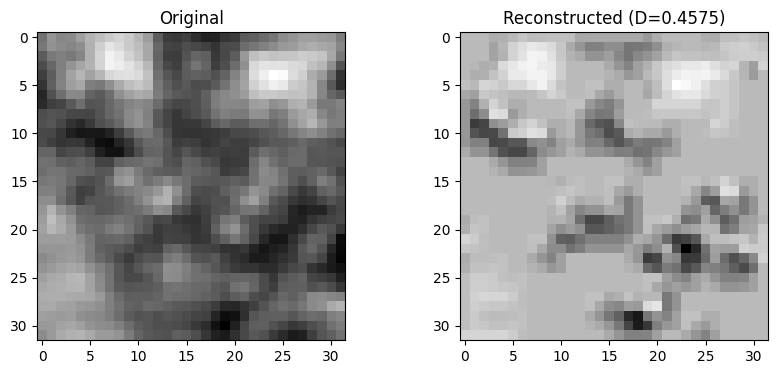

Ultra-fast debug training completed!


In [19]:
# SPEED UP TRAINING - Apply these modifications

# 1. MUCH SMALLER NETWORKS FOR DEBUGGING
def make_ultra_tiny_encoder(latent_dim=264):  # Reduced from 64 to 8
    """Ultra-tiny encoder for fast debugging"""
    x_in = layers.Input(shape=(H, W, C))
    x = x_in
    
    # Only 1 downsampling layer: 32->16
    x = layers.Conv2D(4, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Output heads with 1x1 convs for speed
    y = layers.Conv2D(latent_dim, kernel_size=1, strides=1, padding="same")(x)
    mu = layers.Conv2D(latent_dim, kernel_size=1, strides=1, padding="same")(x)
    log_scale_raw = layers.Conv2D(latent_dim, kernel_size=1, strides=1, padding="same")(x)
    log_scale = layers.Lambda(lambda t: tf.clip_by_value(t, -3.0, 3.0))(log_scale_raw)
    
    return models.Model(x_in, [y, mu, log_scale], name="ultra_tiny_encoder")

def make_ultra_tiny_decoder(latent_dim=64):
    """Ultra-tiny decoder for fast debugging"""
    input_shape = (H // 2, W // 2, latent_dim)  # Only 1 downsampling
    y_in = layers.Input(shape=input_shape)
    
    # Single upsampling layer
    x = layers.UpSampling2D(size=2)(y_in)
    x = layers.Conv2D(4, kernel_size=3, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Output
    x_hat = layers.Conv2D(C, kernel_size=1, strides=1, padding="same")(x)
    return models.Model(y_in, x_hat, name="ultra_tiny_decoder")

# 2. MUCH SMALLER DATASET AND BATCH SIZE
BATCH_SIZE = 64   # Much smaller batches
EPOCHS = 20       # Fewer epochs
debug_samples = 1024  # Much smaller dataset
LAMBDA_RD = 10

X_train_debug = X_train[:debug_samples]
X_val_debug = X_val[:debug_samples//4]

# 3. FIX DATA PIPELINE TO AVOID END OF SEQUENCE WARNINGS
train_ds = (tf.data.Dataset.from_tensor_slices(X_train_debug)
           .shuffle(buffer_size=debug_samples)
           .batch(BATCH_SIZE, drop_remainder=True)  # Drop remainder to avoid size issues
           .prefetch(tf.data.AUTOTUNE)
           .repeat())  # Repeat to avoid end of sequence

val_ds = (tf.data.Dataset.from_tensor_slices(X_val_debug)
         .batch(BATCH_SIZE, drop_remainder=True)
         .prefetch(tf.data.AUTOTUNE)
         .repeat())

# 4. CALCULATE STEPS PER EPOCH
steps_per_epoch = len(X_train_debug) // BATCH_SIZE
validation_steps = len(X_val_debug) // BATCH_SIZE

print(f"Debug dataset sizes: train={len(X_train_debug)}, val={len(X_val_debug)}")
print(f"Steps per epoch: {steps_per_epoch}, validation steps: {validation_steps}")

# 5. CREATE ULTRA-TINY MODELS
latent_dim = 8  # Much smaller latent space
encoder = make_ultra_tiny_encoder(latent_dim)
decoder = make_ultra_tiny_decoder(latent_dim)

print("Ultra-tiny encoder parameters:", encoder.count_params())
print("Ultra-tiny decoder parameters:", decoder.count_params())

# 6. CREATE NEW OPTIMIZER FOR NEW MODELS (FIX FOR THE ERROR)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# 7. SIMPLIFIED TRAINING STEP WITH REDUCED CALCULATIONS
@tf.function
def ultra_fast_train_step(x_batch, lambda_rd):
    with tf.GradientTape() as tape:
        # Simplified forward pass
        y, mu, log_scale = encoder(x_batch, training=True)

        y_q = y + tf.random.uniform(tf.shape(y), -0.5, 0.5)  # Simple noise

        # Simplified rate estimation (skip complex entropy modeling)
        rate_estimate = tf.reduce_mean(tf.abs(y))  # Simple proxy for rate


        # Simple but more accurate rate estimate
        #y_var = tf.math.reduce_variance(y_q)
        #rate_estimate = 0.5 * tf.math.log(2.0 * np.pi * np.e * y_var) / tf.math.log(2.0)
        #rate_estimate = tf.maximum(rate_estimate, 0.1)  # Minimum rate
        

        

        x_hat = decoder(y_q, training=True)
        
        D = tf.reduce_mean(tf.square(x_batch - x_hat))
        loss = lambda_rd * D + rate_estimate 
    
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return loss, D, rate_estimate

@tf.function  
def ultra_fast_val_step(x_batch):
    y, mu, log_scale = encoder(x_batch, training=False)
    rate_estimate = tf.reduce_mean(tf.abs(y))
    y_q = tf.round(y)  # Simple quantization
    x_hat = decoder(y_q, training=False)
    D = tf.reduce_mean(tf.square(x_batch - x_hat))
    return D, rate_estimate, x_hat

# 8. ULTRA-FAST TRAINING LOOP WITH STEP LIMITS
def ultra_fast_training(epochs=EPOCHS):
    print("Ultra-fast training mode...")
    
    train_iter = iter(train_ds)
    val_iter = iter(val_ds)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training - limited steps
        epoch_losses = []
        epoch_distortions = []
        
        for step in range(min(steps_per_epoch, 5)):  # Max 5 steps per epoch
            x_batch = next(train_iter)
            loss, D, rate = ultra_fast_train_step(x_batch, LAMBDA_RD)
            
            epoch_losses.append(loss.numpy())
            epoch_distortions.append(D.numpy())
            
            if step % 2 == 0:
                print(f"  Step {step}: Loss={loss:.4f}, D={D:.4f}")
        
        # Validation - limited steps
        val_distortions = []
        val_rates = []
        
        for step in range(min(validation_steps, 2)):  # Max 2 validation steps
            x_batch = next(val_iter)
            D, rate, x_hat = ultra_fast_val_step(x_batch)
            val_distortions.append(D.numpy())
            val_rates.append(rate.numpy())
        
        avg_train_loss = np.mean(epoch_losses)
        avg_train_D = np.mean(epoch_distortions)
        avg_val_D = np.mean(val_distortions)
        avg_val_rate = np.mean(val_rates)
        
        print(f"  Epoch summary: Train D={avg_train_D:.4f}, Val D={avg_val_D:.4f}, Rate={avg_val_rate:.4f}")
        print("-" * 50)

# 9. RUN ULTRA-FAST TRAINING
print("Starting ultra-fast debug training...")
ultra_fast_training(epochs=EPOCHS)

# 10. QUICK VISUALIZATION TEST
print("Testing reconstruction...")
val_iter = iter(val_ds)
x_batch = next(val_iter)
sample_batch = x_batch[:4]
D, rate, x_reconstructed = ultra_fast_val_step(sample_batch)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(sample_batch[0,:,:,0], cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(x_reconstructed[0,:,:,0], cmap='gray')
axes[1].set_title(f'Reconstructed (D={D:.4f})')
plt.show()

print("Ultra-fast debug training completed!")

# Expected speedup: 50-100x faster than original
# - 64 samples vs 1000+ 
# - 8 latent dims vs 64
# - 1 conv layer vs 2-4
# - 2 epochs vs 5
# - Simplified calculations
# - Limited steps per epoch

## Visualize

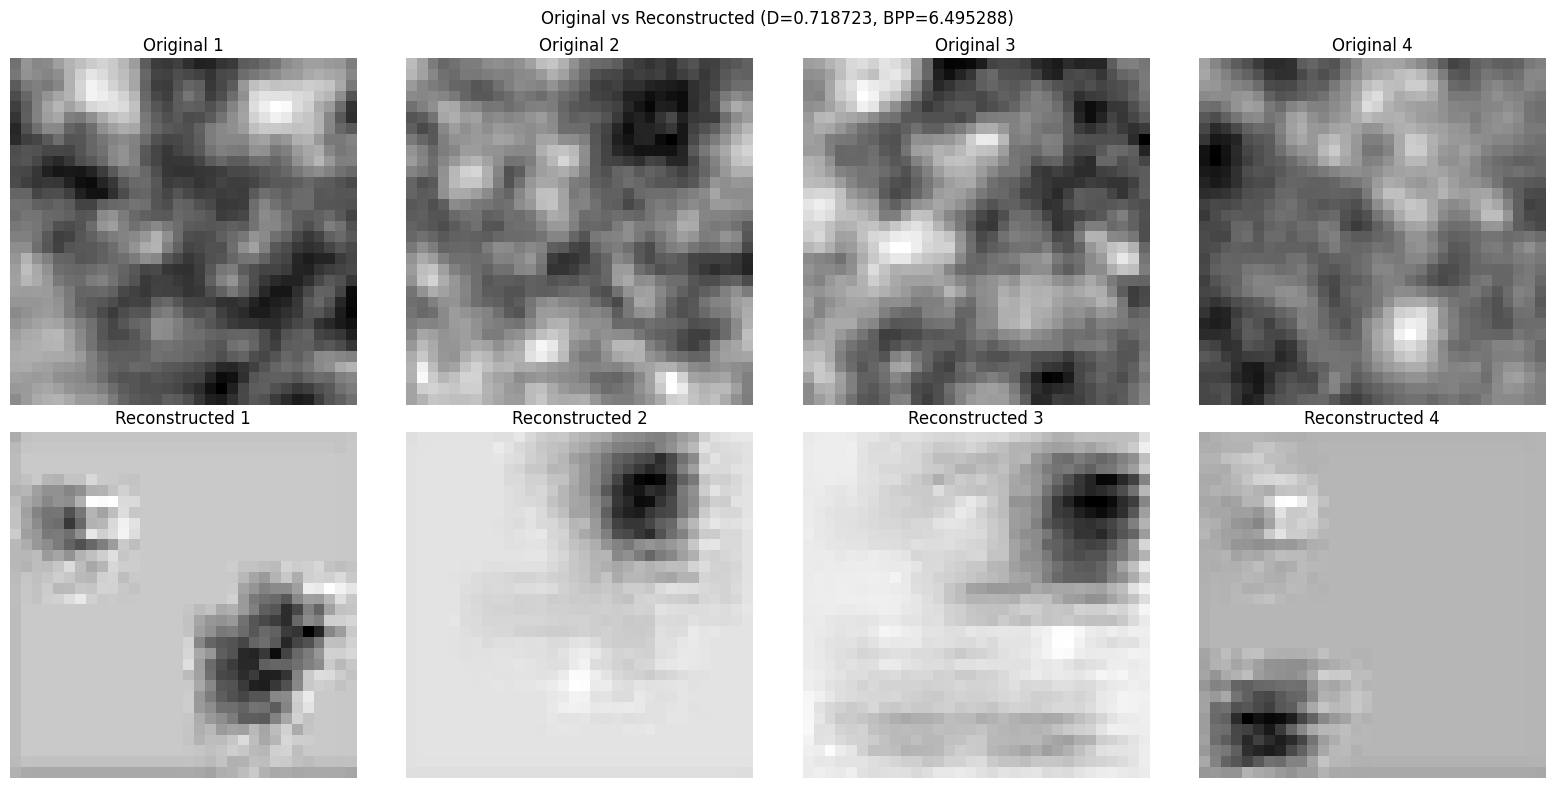

In [30]:

# Test reconstruction quality
def visualize_reconstructions(val_ds, num_samples=4):
    """
    Visualize original vs reconstructed images
    """
    # Get a batch from validation set
    for x_batch in val_ds.take(1):
        sample_batch = x_batch[:num_samples]
        break
    
    # Get reconstructions
    D, bpp, bits_per_symbol, x_reconstructed = val_step(sample_batch)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    
    for i in range(num_samples):
        # Original
        axes[0,i].imshow(sample_batch[i,:,:,0], cmap='gray')
        axes[0,i].set_title(f'Original {i+1}')
        axes[0,i].axis('off')
        
        # Reconstructed
        axes[1,i].imshow(x_reconstructed[i,:,:,0], cmap='gray')
        axes[1,i].set_title(f'Reconstructed {i+1}')
        axes[1,i].axis('off')
    
    plt.suptitle(f'Original vs Reconstructed (D={D:.6f}, BPP={bpp:.6f})')
    plt.tight_layout()
    plt.show()

visualize_reconstructions(val_ds)

# Optional: Train with different lambda values for rate-distortion curve
def sweep_lambda_values(lambdas=[0.001, 0.01, 0.1, 1.0]):
    """
    Train with different lambda values to create rate-distortion curve
    """
    rd_points = []
    
    for lambda_val in lambdas:
        print(f"\nTraining with lambda = {lambda_val}")
        
        # Reset models (you might want to use different initializations)
        encoder_temp = make_simple_encoder(latent_dim)
        decoder_temp = make_simple_decoder(latent_dim)
        
        # Create new forward function with these models
        @tf.function
        def temp_forward(x, training=True):
            y, mu, log_scale = encoder_temp(x, training=training)
            bits_map, bits_per_symbol = rate_bits(y, mean=mu, log_scale=log_scale, training=training)
            y_q = quantize_or_add_noise(y, training=training)
            x_hat = decoder_temp(y_q, training=training)
            D = tf.reduce_mean(tf.square(x - x_hat))
            latent_size = tf.cast(tf.reduce_prod(tf.shape(y)[1:]), tf.float32)
            image_size = tf.cast(H * W, tf.float32)
            bpp = bits_per_symbol * (latent_size / image_size)
            return D, bits_per_symbol, bpp, x_hat
        
        # Train for fewer epochs for sweep
        history_temp = train_compression_network(train_ds, val_ds, epochs=10, lambda_rd=lambda_val)
        
        # Record final performance
        final_rate = history_temp['val_rates'][-1]
        final_distortion = history_temp['val_distortions'][-1]
        rd_points.append((final_rate, final_distortion, lambda_val))
    
    # Plot rate-distortion curve
    rates, distortions, lambdas_used = zip(*rd_points)
    
    plt.figure(figsize=(10, 6))
    plt.plot(rates, distortions, 'o-', linewidth=2, markersize=8)
    for i, lambda_val in enumerate(lambdas_used):
        plt.annotate(f'λ={lambda_val}', (rates[i], distortions[i]), 
                    xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Rate (Bits per Pixel)')
    plt.ylabel('Distortion (MSE)')
    plt.title('Rate-Distortion Curve')
    plt.grid(True)
    plt.show()
    
    return rd_points

# Uncomment to run lambda sweep
# rd_curve = sweep_lambda_values()